## Loading the data

In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [46]:
retail_df = pd.read_excel("/Users/sukanyak/Desktop/Online Retail.xlsx")

In [47]:
retail_df.head(10)
retail_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
InvoiceNo      541909 non-null object
StockCode      541909 non-null object
Description    540455 non-null object
Quantity       541909 non-null int64
InvoiceDate    541909 non-null datetime64[ns]
UnitPrice      541909 non-null float64
CustomerID     406829 non-null float64
Country        541909 non-null object
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


## Data Cleaning

In [48]:
#Unique number of entries in each column
retail_df.nunique()

InvoiceNo      25900
StockCode       4070
Description     4223
Quantity         722
InvoiceDate    23260
UnitPrice       1630
CustomerID      4372
Country           38
dtype: int64

In [49]:
#Check for missing values in the data
retail_df.isnull().sum(axis=0)

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [50]:
#Removing the null values in customerID. We are going to assign RFM values based on customerID so null can't exist.
#Also check if there are non positive values in columns that should be greater than 0.
retail_df = retail_df[pd.notnull(retail_df['CustomerID'])]
retail_df.Quantity.min()

-80995

In [51]:
#Removing negative values from Quantity as it can't be less than zero.
retail_df = retail_df[(retail_df['Quantity']>0)]
retail_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 397924 entries, 0 to 541908
Data columns (total 8 columns):
InvoiceNo      397924 non-null object
StockCode      397924 non-null object
Description    397924 non-null object
Quantity       397924 non-null int64
InvoiceDate    397924 non-null datetime64[ns]
UnitPrice      397924 non-null float64
CustomerID     397924 non-null float64
Country        397924 non-null object
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 27.3+ MB


In [54]:
#Calculate Total price from quantity and unit price
retail_df['TotalPrice'] = retail_df['Quantity'] * retail_df['UnitPrice']

In [55]:
#the first order date in the data
retail_df['InvoiceDate'].min()

Timestamp('2010-12-01 08:26:00')

In [56]:
#the last date of order in the data
retail_df.InvoiceDate.max()

Timestamp('2011-12-09 12:50:00')

## Q4a
### Calculate Recency, Frequency and Monetary Value for each Customer ID

In [58]:
#To calculate recency, we will take the last day of the invoice date. i.e. 31.10.2011
import datetime as dt
ZeroHour = dt.datetime(2011,12,9)

In [59]:
retail_df['InvoiceDate'] = pd.to_datetime(retail_df['InvoiceDate'])

In [60]:
#Now create the RFM matrix table
RFM_T = retail_df.groupby('CustomerID').agg({'InvoiceDate': lambda x: (ZeroHour - x.max()).days, 'InvoiceNo': lambda x: len(x), 'TotalPrice': lambda x: x.sum()})
RFM_T['InvoiceDate'] = RFM_T['InvoiceDate'].astype(int)
RFM_T.rename(columns={'InvoiceDate': 'recency', 
                         'InvoiceNo': 'frequency', 
                         'TotalPrice': 'monetary_value'}, inplace=True)

In [61]:
RFM_T.head(10)

,recency,frequency,monetary_value
CustomerID,,,
12346.0,324,1,77183.60
12347.0,1,182,4310.00
12348.0,74,31,1797.24
12349.0,17,73,1757.55
12350.0,309,17,334.40
12352.0,35,85,2506.04
12353.0,203,4,89.00
12354.0,231,58,1079.40
12355.0,213,13,459.40


## Q4b
### Find out top 10 customers based on frequency and monetary value

In [62]:
#By Frequency
RFM_T.sort_values('frequency', ascending=False).head(10)

,recency,frequency,monetary_value
CustomerID,,,
17841.0,0,7847,40991.57
14911.0,0,5677,143825.06
14096.0,3,5111,65164.79
12748.0,-1,4596,33719.73
14606.0,0,2700,12156.65
15311.0,-1,2379,60767.90
14646.0,0,2080,280206.02
13089.0,1,1818,58825.83
13263.0,0,1677,7454.07


In [63]:
#By Monetary Value
RFM_T.sort_values('monetary_value',ascending=False).head(10)

,recency,frequency,monetary_value
CustomerID,,,
14646.0,0,2080,280206.02
18102.0,-1,431,259657.30
17450.0,7,337,194550.79
16446.0,-1,3,168472.50
14911.0,0,5677,143825.06
12415.0,23,716,124914.53
14156.0,8,1400,117379.63
17511.0,1,963,91062.38
16029.0,37,242,81024.84


In [65]:
# Calculating RFM scores for each customer. For that, we first calculate the quartile values for RFM
quartiles = RFM_T.quantile(q=[0.25,0.50,0.75])
print(quartiles, type(quartiles))

# Making a dictionary out of the quartiles so that it can be used to give scores to each record
quartiles=quartiles.to_dict()
quartiles

      recency  frequency  monetary_value
0.25     16.0       17.0         307.245
0.50     49.0       41.0         674.450
0.75    140.5      100.0        1661.640 <class 'pandas.core.frame.DataFrame'>


{'recency': {0.25: 16.0, 0.5: 49.0, 0.75: 140.5},
 'frequency': {0.25: 17.0, 0.5: 41.0, 0.75: 100.0},
 'monetary_value': {0.25: 307.24499999999995,
  0.5: 674.4499999999998,
  0.75: 1661.64}}

In [66]:
# for Recency. the scoring would be opposite of frequency and monetary as higher values means lower scores here.

def RClass(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]: 
        return 3
    else:
        return 4
    
# for Frequency and Monetary value 

def FMClass(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]: 
        return 2
    else:
        return 1    

In [67]:
rfmScores = RFM_T
rfmScores['R_Quartile'] = rfmScores['recency'].apply(RClass, args=('recency',quartiles,))
rfmScores['F_Quartile'] = rfmScores['frequency'].apply(FMClass, args=('frequency',quartiles,))
rfmScores['M_Quartile'] = rfmScores['monetary_value'].apply(FMClass, args=('monetary_value',quartiles,))

In [68]:
rfmScores.head(10)

,recency,frequency,monetary_value,R_Quartile,F_Quartile,M_Quartile
CustomerID,,,,,,
12346.0,324,1,77183.60,4,4,1
12347.0,1,182,4310.00,1,1,1
12348.0,74,31,1797.24,3,3,1
12349.0,17,73,1757.55,2,2,1
12350.0,309,17,334.40,4,4,3
12352.0,35,85,2506.04,2,2,1
12353.0,203,4,89.00,4,4,4
12354.0,231,58,1079.40,4,2,2
12355.0,213,13,459.40,4,4,3


In [73]:
#Creating a new dataframe to only have the scores
rfmScores_new = rfmScores.drop(['recency', 'frequency', 'monetary_value'], axis=1)

In [74]:
rfmScores_new.head(10)

,R_Quartile,F_Quartile,M_Quartile
CustomerID,,,
12346.0,4,4,1
12347.0,1,1,1
12348.0,3,3,1
12349.0,2,2,1
12350.0,4,4,3
12352.0,2,2,1
12353.0,4,4,4
12354.0,4,2,2
12355.0,4,4,3


## Q4c
### Find out the optimal number of clusters using a dendogram and elbow method

In [81]:
import matplotlib.pyplot as plt
import seaborn as sn
%matplotlib inline

In [82]:
from scipy.cluster.hierarchy import linkage, dendrogram

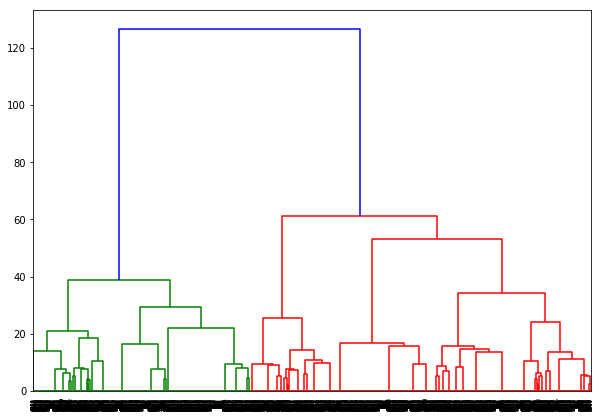

In [85]:
link = linkage(rfmScores_new, method='ward')
plt.figure(figsize=(10,7))
dendrogram(link, orientation='top', distance_sort='descending', show_leaf_counts=True)
plt.show()

Using the dendogram, 2 clusters comes out to be the optimum number of clusters suitable for this dataset

In [86]:
from sklearn.cluster import KMeans

wcss = []
for i in range(1,11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=0)
    kmeans.fit(rfmScores_new)
    wcss.append(kmeans.inertia_)

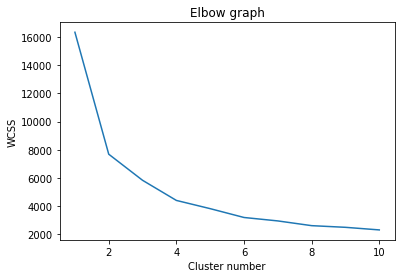

In [87]:
plt.plot(range(1,11), wcss)
plt.title('Elbow graph')
plt.xlabel('Cluster number')
plt.ylabel('WCSS')
plt.show()

Using the elbow method, 4 clusters comes out to be the optimum numbers of clusters for this dataset

## Q4d
### Create final segments of customers and label each customers

In [88]:
#Here, we will use Kmeans clustering with a cluster of 3 to create the final segments.

In [90]:
kmeans = KMeans(n_clusters=3, init='k-means++', random_state=0)
clusters = kmeans.fit_predict(rfmScores_new)

In [91]:
rfmScores['clusters'] = clusters
rfmScores.head()

,recency,frequency,monetary_value,R_Quartile,F_Quartile,M_Quartile,clusters
CustomerID,,,,,,,
12346.0,324,1,77183.60,4,4,1,0
12347.0,1,182,4310.00,1,1,1,1
12348.0,74,31,1797.24,3,3,1,1
12349.0,17,73,1757.55,2,2,1,1
12350.0,309,17,334.40,4,4,3,0


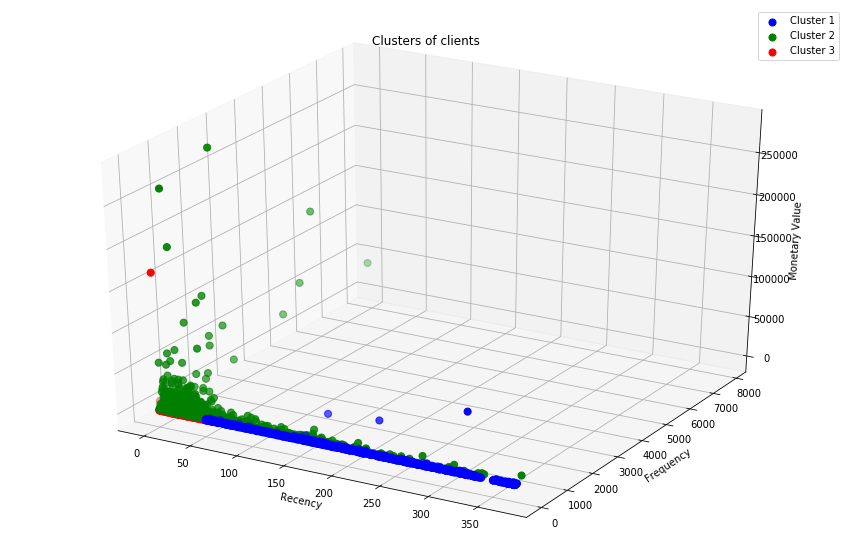

In [99]:
#Plotting a chart to show all 3 clusters that are obtained
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(15,10))
dx = fig.add_subplot(111, projection='3d')
colors = ['blue', 'green', 'red']

for i in range(0,3):
    dx.scatter(rfmScores[rfmScores.clusters == i].recency, 
               rfmScores[rfmScores.clusters == i].frequency, 
               rfmScores[rfmScores.clusters == i].monetary_value, 
               c = colors[i], 
               label = 'Cluster ' + str(i+1), 
               s=50)

dx.set_title('Clusters of clients')
dx.set_xlabel('Recency')
dx.set_ylabel('Frequency')
dx.set_zlabel('Monetary Value')
dx.legend()

## Q4e
### Explain each segment

#### Cluster Blue
The customers in this segment are non frequent buyers, haven't bought anything recently and spend less. This would be the last priority for marketing managers for advertising/promotion strategies.

#### Cluster Red
The customers in this segment are non frequent buyers, who have bought products very recently but spend less money.

#### Cluster Green
The customers in this segment have a very wide range of buyers, although it is focused on recent purchasers, less frequently and comparatively high money spenders as compared to other segments.